# Setup of the Environment

In [1]:
# Unpack the pickle file (Mainly a Colab thing)
!unzip pickle.zip

Archive:  pickle.zip
replace pickle/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Python Libraries

In [2]:
import tensorflow as tf
import numpy as np
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda
from keras.utils.np_utils import to_categorical
import VariantCalling as vc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress
from sklearn.metrics import r2_score

# Parameters for the run

In [32]:
run_sequence = "CRT"
nb_epoch = 100
batch_size = 16
nb_filters = 48
nb_conv = 5
nb_pool = 3
nb_alignment = 2500
nb_channel = 5
nb_coverage = 100
nb_node = 128
train_loop = 0

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
hfont = {'fontname':'serif'}

# Initialising variables based on the specified genome sequence

In [4]:
if run_sequence == "CRT":
    img_row, img_col = 101, 178
    clone_names = ["3D7","7G8","DD2"]
    nb_mutations = len(clone_names)
    ref_file_name = "clones.txt"
elif run_sequence == "DHPS":
    img_row, img_col = 101, 642
    clone_names = ["3D7","DD2","HB3"]
    nb_mutations = len(clone_names)
    ref_file_name = "dhps_clones.txt"
elif run_sequence == "DHFR":
    img_row, img_col = 101, 491
    clone_names = ["3D7","7G8","DD2","HB3"]
    nb_mutations = len(clone_names)
    ref_file_name = "dhfr_clones.txt"
#  Concatenate this section in the future for other genome sequences

# Defining the class for TF/Keras callbacks to save the best model

In [5]:
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_mse', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_weights = self.model.get_weights()

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_weights= self.model.get_weights()

# Section 1: Conventional Training
Here we train the model using the unpacked pickles files.

### Creating the VariantCalling *class* object to Synthesise Pile-ups from Pickle Files

In [6]:
dg = vc.VariantCallingData(file_name=ref_file_name,gen_mode=2,pkl_sequence=run_sequence,pkl_clones=clone_names)
alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,0.01,0.01)
prob_lists = (np.array(prob_lists)*100).tolist()
alignments = [dg._array_constituent_bp(i,101,True) for i in alignments_raw]
alignments = dg.char_to_int(alignments)

Progress:  0.0% completed. 	Computing alignment 0 of 2500
Progress:  5.0% completed. 	Computing alignment 125 of 2500
Progress:  10.0% completed. 	Computing alignment 250 of 2500
Progress:  15.0% completed. 	Computing alignment 375 of 2500
Progress:  20.0% completed. 	Computing alignment 500 of 2500
Progress:  25.0% completed. 	Computing alignment 625 of 2500
Progress:  30.0% completed. 	Computing alignment 750 of 2500
Progress:  35.0% completed. 	Computing alignment 875 of 2500
Progress:  40.0% completed. 	Computing alignment 1000 of 2500
Progress:  45.0% completed. 	Computing alignment 1125 of 2500
Progress:  50.0% completed. 	Computing alignment 1250 of 2500
Progress:  55.0% completed. 	Computing alignment 1375 of 2500
Progress:  60.0% completed. 	Computing alignment 1500 of 2500
Progress:  65.0% completed. 	Computing alignment 1625 of 2500
Progress:  70.0% completed. 	Computing alignment 1750 of 2500
Progress:  75.0% completed. 	Computing alignment 1875 of 2500
Progress:  80.0% com

### Display the Pile-ups for Documentation

[26.0, 39.0, 35.0]


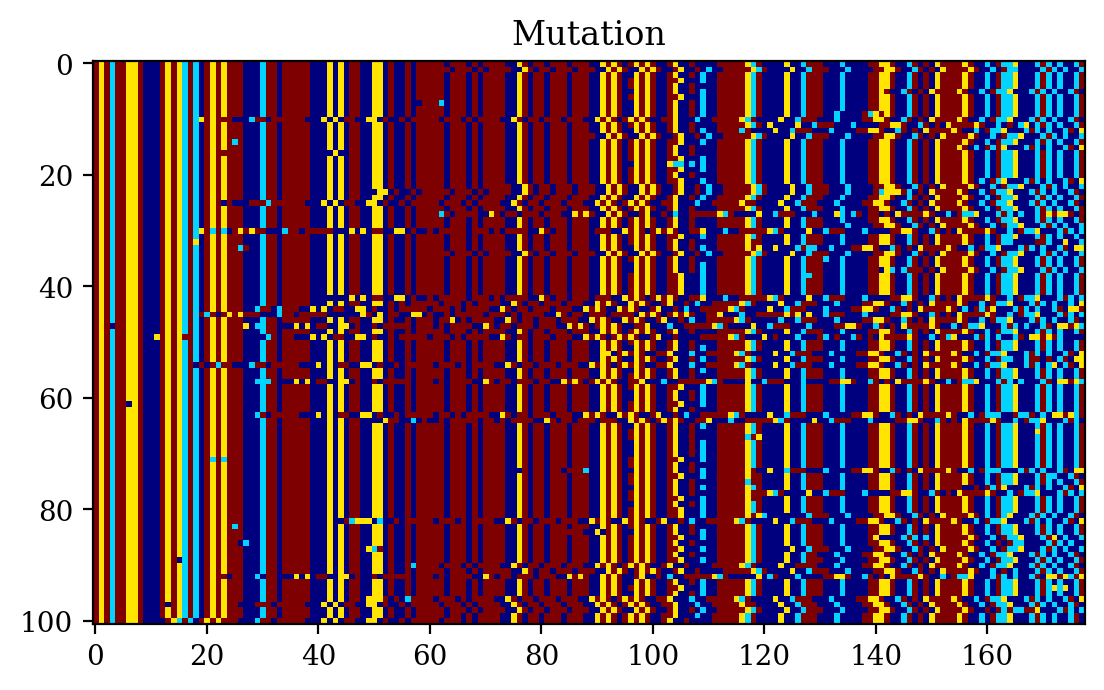

In [7]:
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.title("Mutation")
plt.imshow(dg.char_to_int([dg._array_dup(alignments_raw[0],101)])[0][0],cmap='jet')
print(prob_lists[0])

### Display the Binary Map (also for documentation)

[26.0, 39.0, 35.0]


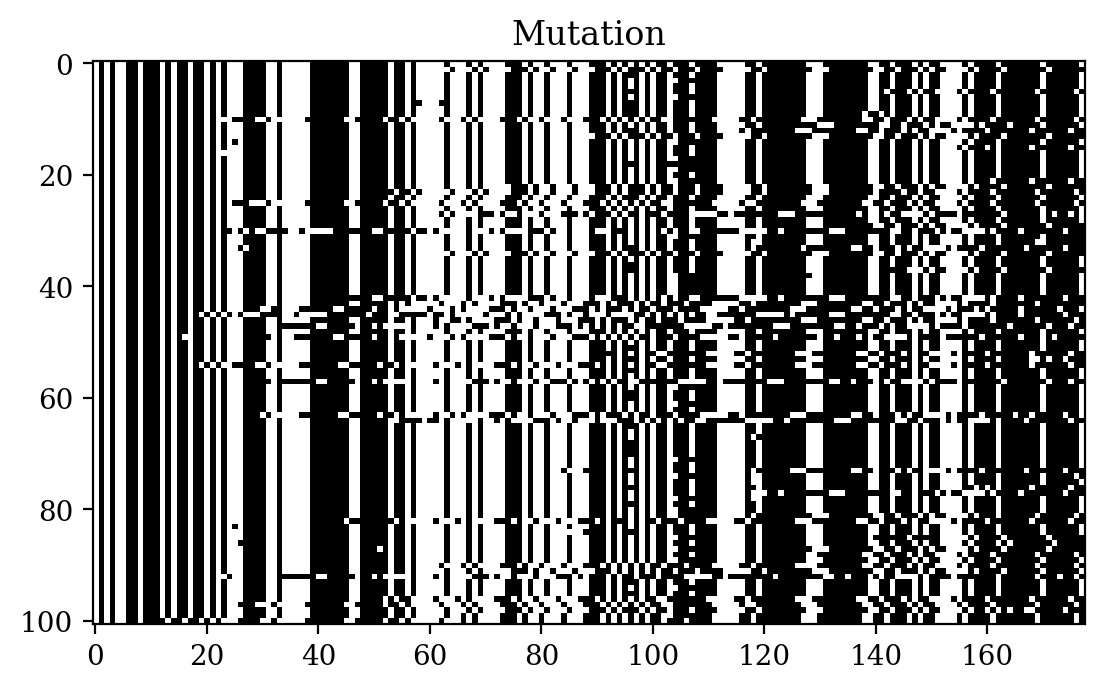

In [8]:
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.title("Mutation")
plt.imshow(alignments[0][1], cmap='Greys_r')
#test_array = np.zeros((178, 100))
#plt.imshow(test_array, cmap='Greys')
print(prob_lists[0])

### Pre-process the Synthesised Pile-ups into Train/Test Set

In [9]:
rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
idxs = np.arange(alignments.shape[0])

rng.shuffle(idxs)

split_idx = int(alignments.shape[0]*0.8)
train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
#train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]

print(train_alignments.shape)
print(valid_alignments.shape)


train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)

train_alignments = train_alignments.astype('float32')
valid_alignments = valid_alignments.astype('float32')

train_alignments /= 3
valid_alignments /= 3


(2000, 5, 101, 178)
(500, 5, 101, 178)


### Declaration of the Network Architecture

In [10]:
model = Sequential()
model.add(Conv2D(nb_filters, nb_conv, nb_conv))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool)))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Flatten())
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
#model.add(Dense(nb_node))
#model.add(Dropout(0.2))
#model.add(Activation('relu'))
model.add(Dense(nb_mutations))
model.add(Activation('softmax'))
model.add(Lambda(lambda x: x * 100))
model.compile(metrics=['mse'],loss='categorical_crossentropy',optimizer='adam')

### Initial Training and Follow-up Training

In [11]:
# Here we first train the model
save_best_model = SaveBestModel()
trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
model.set_weights(save_best_model.best_weights)

# Here we resynthesise the pile-ups and continue the trainig using fresh data.
# Primarily because the memory constraints on Colab

for _ in range(0,train_loop):
    """
    This section to test ratio_gen, which is wrapper for alignments
    """
    alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,0.01,0.01)
    prob_lists = (np.array(prob_lists)*100).tolist()
    alignments = [dg._array_constituent_bp(i,101,True) for i in alignments_raw]
    alignments = dg.char_to_int(alignments)
    rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
    idxs = np.arange(alignments.shape[0])
    rng.shuffle(idxs)
    split_idx = int(alignments.shape[0]*0.8)
    train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
    train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
    #train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
    print(train_alignments.shape)
    print(train_prob_lists.shape)
    print(train_alignments.shape)
    print(valid_alignments.shape)
    train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
    valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)
    train_alignments = train_alignments.astype('float32')
    valid_alignments = valid_alignments.astype('float32')
    train_alignments /= 3
    valid_alignments /= 3
    trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
    model.set_weights(save_best_model.best_weights)

Epoch 1/100
125/125 [==============================] - 14s 14ms/step - loss: 109.8872 - mse: 316.2182 - val_loss: 109.8894 - val_mse: 314.9777
Epoch 2/100
125/125 [==============================] - 1s 10ms/step - loss: 109.5872 - mse: 309.7433 - val_loss: 104.3052 - val_mse: 192.2774
Epoch 3/100
125/125 [==============================] - 1s 9ms/step - loss: 104.4302 - mse: 202.3977 - val_loss: 103.1364 - val_mse: 172.7948
Epoch 4/100
125/125 [==============================] - 1s 9ms/step - loss: 103.3955 - mse: 182.4770 - val_loss: 102.8517 - val_mse: 166.8137
Epoch 5/100
125/125 [==============================] - 1s 8ms/step - loss: 103.0843 - mse: 175.8842 - val_loss: 102.6991 - val_mse: 162.1979
Epoch 6/100
125/125 [==============================] - 1s 9ms/step - loss: 102.8507 - mse: 169.4067 - val_loss: 102.6562 - val_mse: 161.5133
Epoch 7/100
125/125 [==============================] - 1s 10ms/step - loss: 102.7431 - mse: 166.1359 - val_loss: 102.7127 - val_mse: 161.1190
Epoch 8/1

### Evaluate the Model Performance

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 35, 48)        6048      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 11, 48)        0         
 )                                                               
                                                                 
 activation (Activation)     (None, 6, 11, 48)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 3, 48)          57648     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 48)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 1, 48)          0

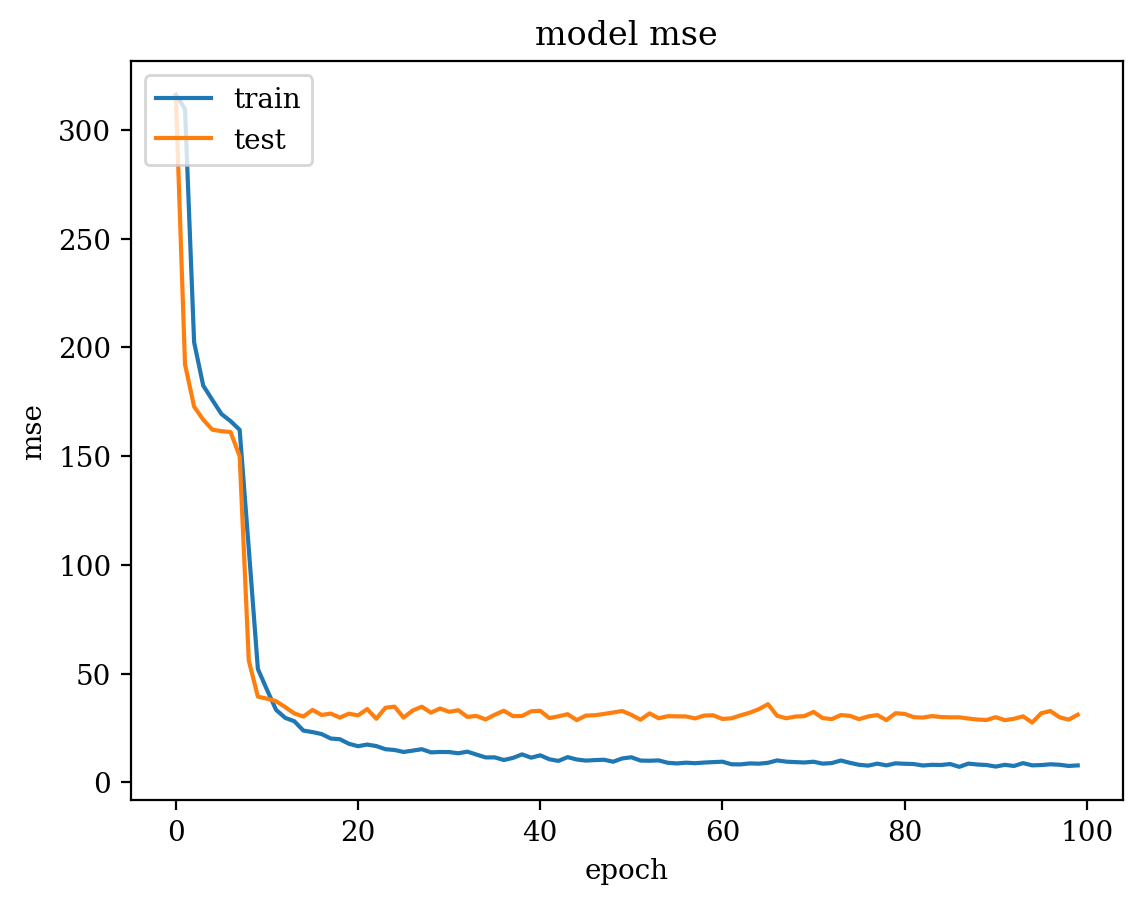

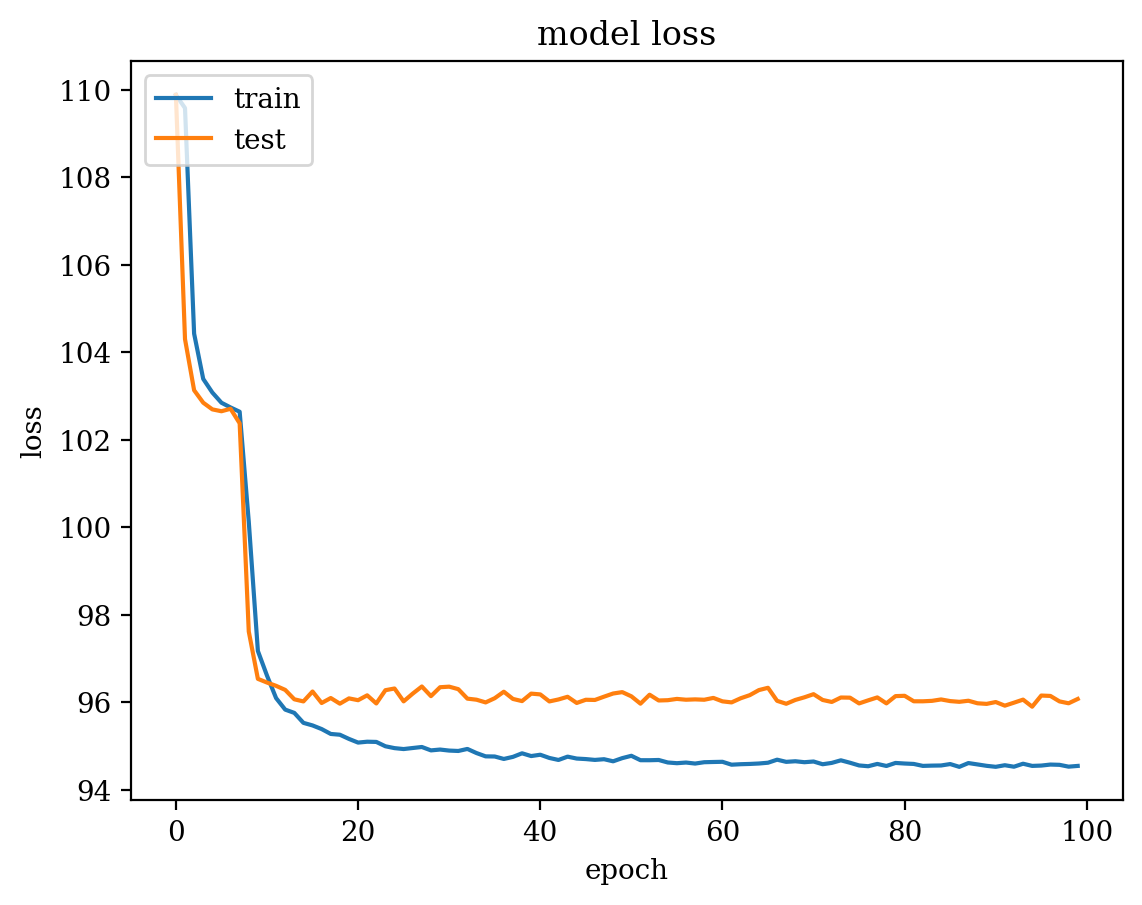

In [12]:
model.summary()
print(trained_model.history.keys())
# summarize history for accuracy
plt.plot(trained_model.history['mse'])
plt.plot(trained_model.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.save('normal.h5')

### Evaluation on the Test Set

16/16 [==============================] - 0s 13ms/step


/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


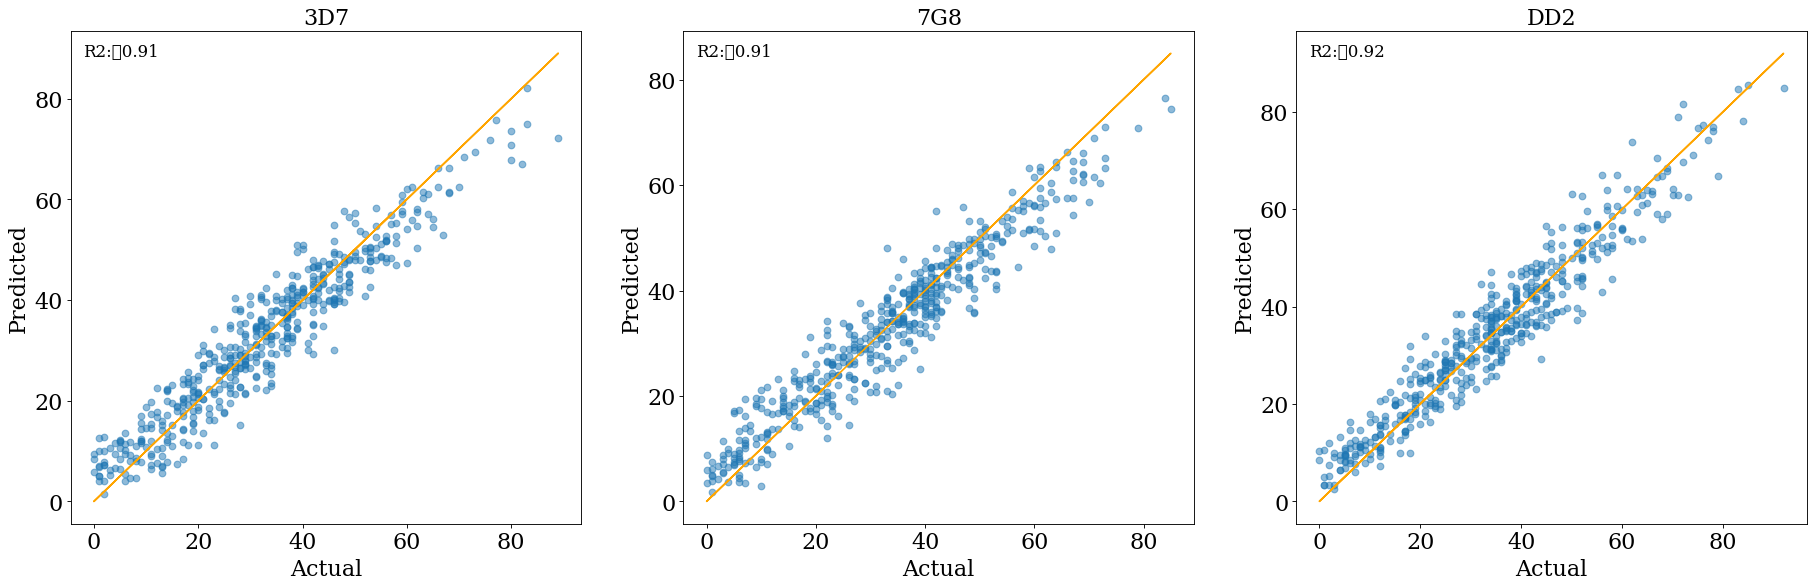

In [13]:
predict_array = model.predict(valid_alignments).tolist()

df_predict_bp_channel = pd.DataFrame(predict_array)
df_actual_bp_channel = pd.DataFrame(valid_prob_lists)

# Setup the headers
df_predict_bp_channel.columns = clone_names
df_actual_bp_channel.columns = clone_names

plt.figure(figsize=(4 + (8*len(clone_names)), 8), dpi=80)
for i in range(0,len(clone_names)):
    plt.subplot(1, len(clone_names), i+1)
    r2_bp_bin = r2_score(df_actual_bp_channel[clone_names[i]], df_predict_bp_channel[clone_names[i]])
    yp_1 = np.polyval([1, 0], df_actual_bp_channel[clone_names[i]])
    plt.plot(df_actual_bp_channel[clone_names[i]], yp_1, color='orange')
    plt.title('{seq_name}'.format(seq_name=clone_names[i]),fontsize=20,**hfont)
    plt.text(0.025, 0.975, 'R2:\t{r2_bp_bin_score}'.format(r2_bp_bin_score=round(r2_bp_bin,2)),
            horizontalalignment='left',
            verticalalignment='top',
            transform=plt.gca().transAxes,fontsize=15,**hfont)
    plt.ylabel('Predicted',fontsize=20,**hfont)
    plt.yticks(fontsize=20,**hfont)
    plt.xlabel('Actual',fontsize=20,**hfont)
    plt.xticks(fontsize=20,**hfont)
    plt.scatter(df_actual_bp_channel[clone_names[i]], df_predict_bp_channel[clone_names[i]],alpha=0.5)


### Print the MSE Score for Each Clones

In [14]:
ax = 0
mse_bp_channel = []

for i in range(0,len(clone_names)):
    mse_bp_channel.append(((df_predict_bp_channel[clone_names[i]] - df_actual_bp_channel[clone_names[i]])**2).mean(axis=ax))

for i in range(0,len(clone_names)):
    print_string = str(mse_bp_channel[i])
    print(print_string)

28.69572621067131
28.139757745652467
25.58405944799354


### Print the Predicted Score for Single Pile-up

In [15]:
print(valid_prob_lists[1])
print(df_predict_bp_channel.iloc[1])

[37. 50. 13.]
3D7    33.428585
7G8    51.058300
DD2    15.513108
Name: 1, dtype: float64


# Section 2: Curriculum Learning
## Here we first train using perfectly clean simulation data, followed by a second training using the unpacked pickle file

### Creating the VariantCalling *class* object to Simulate Pile-ups from Pickle Files

In [16]:
dg = vc.VariantCallingData(file_name=ref_file_name,gen_mode=1,pkl_sequence=run_sequence,pkl_clones=clone_names)
alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,0.01,0.01)
prob_lists = (np.array(prob_lists)*100).tolist()
alignments = [dg._array_constituent_bp(i,101,True) for i in alignments_raw]
alignments = dg.char_to_int(alignments)

Progress:  0.0% completed. 	Computing alignment 0 of 2500
Progress:  5.0% completed. 	Computing alignment 125 of 2500
Progress:  10.0% completed. 	Computing alignment 250 of 2500
Progress:  15.0% completed. 	Computing alignment 375 of 2500
Progress:  20.0% completed. 	Computing alignment 500 of 2500
Progress:  25.0% completed. 	Computing alignment 625 of 2500
Progress:  30.0% completed. 	Computing alignment 750 of 2500
Progress:  35.0% completed. 	Computing alignment 875 of 2500
Progress:  40.0% completed. 	Computing alignment 1000 of 2500
Progress:  45.0% completed. 	Computing alignment 1125 of 2500
Progress:  50.0% completed. 	Computing alignment 1250 of 2500
Progress:  55.0% completed. 	Computing alignment 1375 of 2500
Progress:  60.0% completed. 	Computing alignment 1500 of 2500
Progress:  65.0% completed. 	Computing alignment 1625 of 2500
Progress:  70.0% completed. 	Computing alignment 1750 of 2500
Progress:  75.0% completed. 	Computing alignment 1875 of 2500
Progress:  80.0% com

### Display the Pile-ups for Documentation

[38.0, 30.0, 32.0]


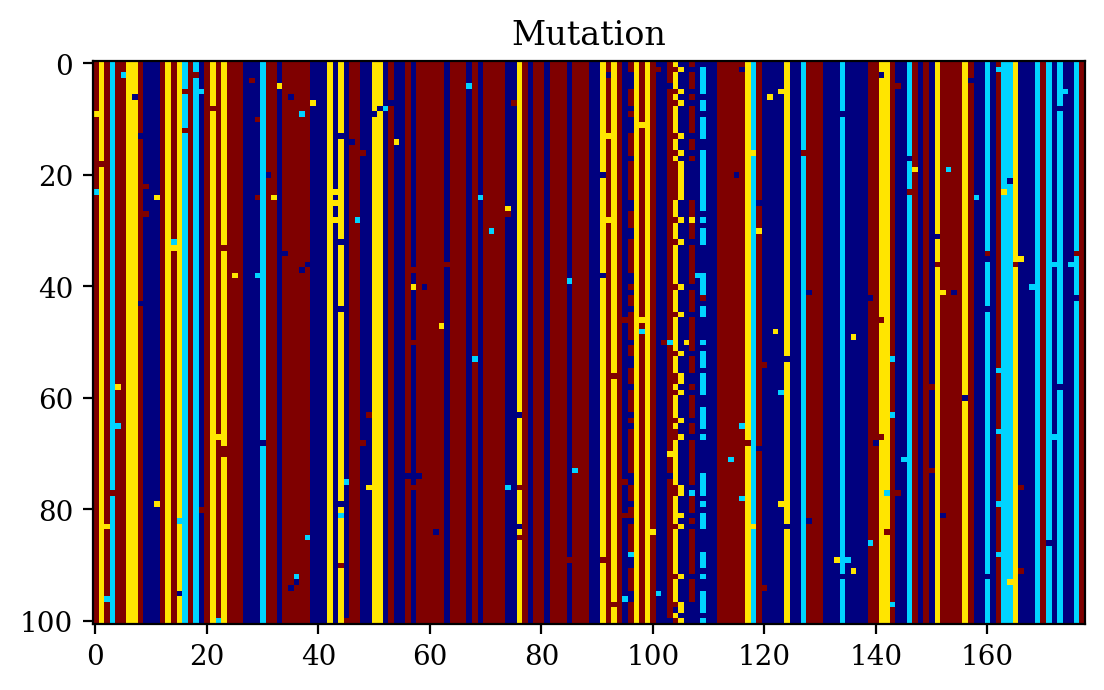

In [17]:
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.title("Mutation")
plt.imshow(dg.char_to_int([dg._array_dup(alignments_raw[0],101)])[0][0],cmap='jet')
print(prob_lists[0])

### Display the Binary Map (also for documentation)

[38.0, 30.0, 32.0]


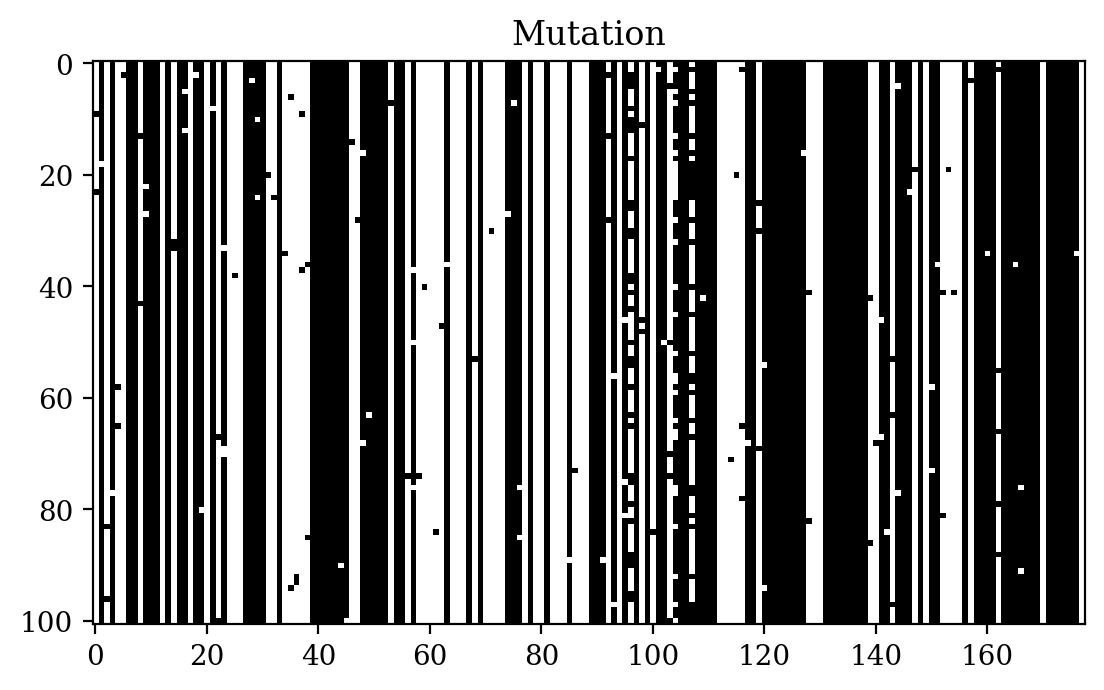

In [18]:
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.title("Mutation")
plt.imshow(alignments[0][1], cmap='Greys_r')
#test_array = np.zeros((178, 100))
#plt.imshow(test_array, cmap='Greys')
print(prob_lists[0])

### Pre-process the Synthesised Pile-ups into Train/Test Set

In [19]:
rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
idxs = np.arange(alignments.shape[0])

rng.shuffle(idxs)

split_idx = int(alignments.shape[0]*0.8)
train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
#train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]

print(train_alignments.shape)
print(valid_alignments.shape)


train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)

train_alignments = train_alignments.astype('float32')
valid_alignments = valid_alignments.astype('float32')

train_alignments /= 3
valid_alignments /= 3


(2000, 5, 101, 178)
(500, 5, 101, 178)


### Declaration of the Network Architecture

In [20]:
model = Sequential()
model.add(Conv2D(nb_filters, nb_conv, nb_conv))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool)))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Flatten())
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
#model.add(Dense(nb_node))
#model.add(Dropout(0.2))
#model.add(Activation('relu'))
model.add(Dense(nb_mutations))
model.add(Activation('softmax'))
model.add(Lambda(lambda x: x * 100))
model.compile(metrics=['mse'],loss='categorical_crossentropy',optimizer='adam')

### Initial Training and Follow-up Training

In [21]:
# Here we first train the model
save_best_model = SaveBestModel()
trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
model.set_weights(save_best_model.best_weights)

# Here we resynthesise the pile-ups and continue the trainig using fresh data.
# Primarily because the memory constraints on Colab

for _ in range(0,train_loop):
    """
    This section to test ratio_gen, which is wrapper for alignments
    """
    alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,0.01,0.01)
    prob_lists = (np.array(prob_lists)*100).tolist()
    alignments = [dg._array_constituent_bp(i,101,True) for i in alignments_raw]
    alignments = dg.char_to_int(alignments)
    rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
    idxs = np.arange(alignments.shape[0])
    rng.shuffle(idxs)
    split_idx = int(alignments.shape[0]*0.8)
    train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
    train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
    #train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
    print(train_alignments.shape)
    print(train_prob_lists.shape)
    print(train_alignments.shape)
    print(valid_alignments.shape)
    train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
    valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)
    train_alignments = train_alignments.astype('float32')
    valid_alignments = valid_alignments.astype('float32')
    train_alignments /= 3
    valid_alignments /= 3
    trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
    model.set_weights(save_best_model.best_weights)

Epoch 1/100
125/125 [==============================] - 6s 14ms/step - loss: 108.6439 - mse: 292.0208 - val_loss: 103.7265 - val_mse: 178.3046
Epoch 2/100
125/125 [==============================] - 1s 8ms/step - loss: 103.0770 - mse: 178.3618 - val_loss: 102.3986 - val_mse: 158.4373
Epoch 3/100
125/125 [==============================] - 1s 8ms/step - loss: 102.5483 - mse: 168.4134 - val_loss: 102.4442 - val_mse: 159.8734
Epoch 4/100
125/125 [==============================] - 1s 8ms/step - loss: 102.2470 - mse: 162.5153 - val_loss: 101.5106 - val_mse: 139.2150
Epoch 5/100
125/125 [==============================] - 1s 9ms/step - loss: 98.1528 - mse: 74.2570 - val_loss: 96.2684 - val_mse: 32.8067
Epoch 6/100
125/125 [==============================] - 1s 10ms/step - loss: 95.7913 - mse: 29.0917 - val_loss: 95.4742 - val_mse: 20.0341
Epoch 7/100
125/125 [==============================] - 1s 11ms/step - loss: 95.3929 - mse: 22.4101 - val_loss: 95.1214 - val_mse: 11.6115
Epoch 8/100
125/125 [=

### Evaluate the Model Performance

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 20, 35, 48)        6048      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 11, 48)        0         
 2D)                                                             
                                                                 
 activation_6 (Activation)   (None, 6, 11, 48)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 3, 48)          57648     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 1, 48)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 1, 1, 48)         

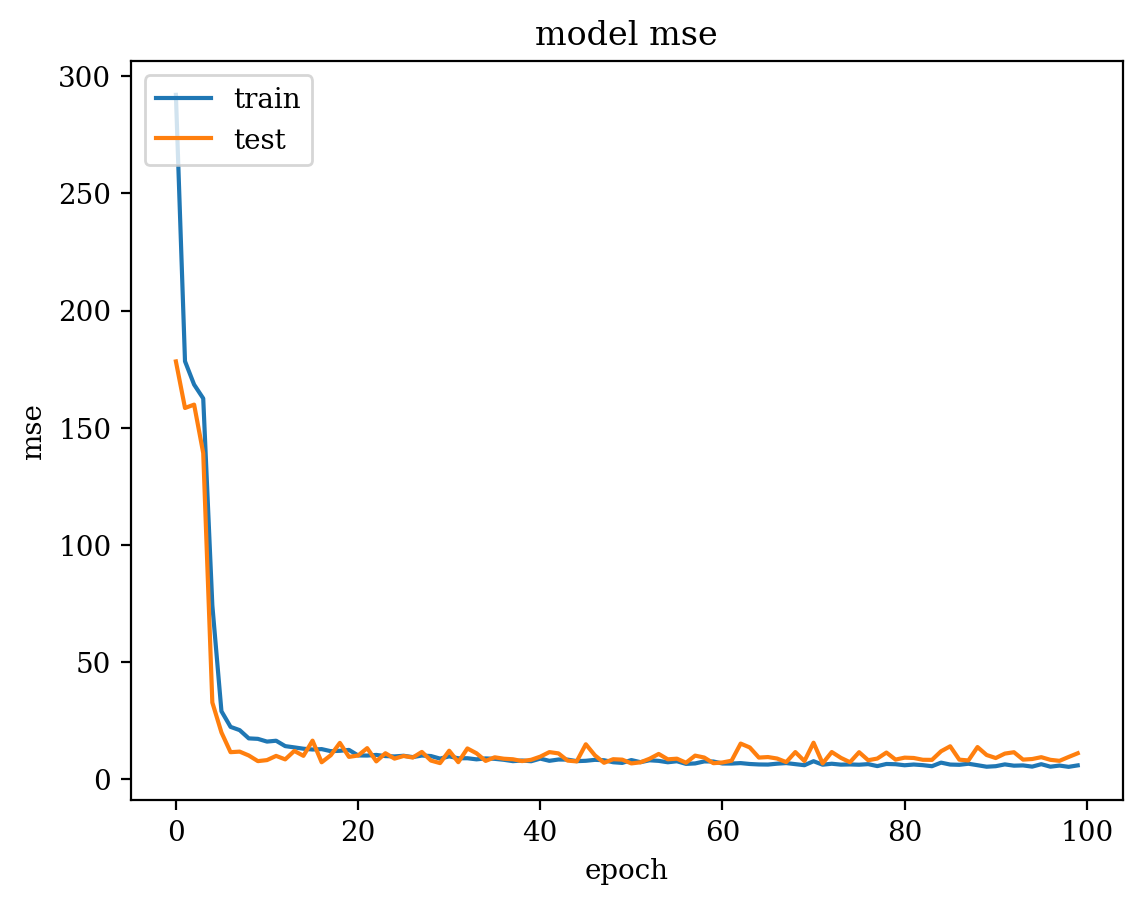

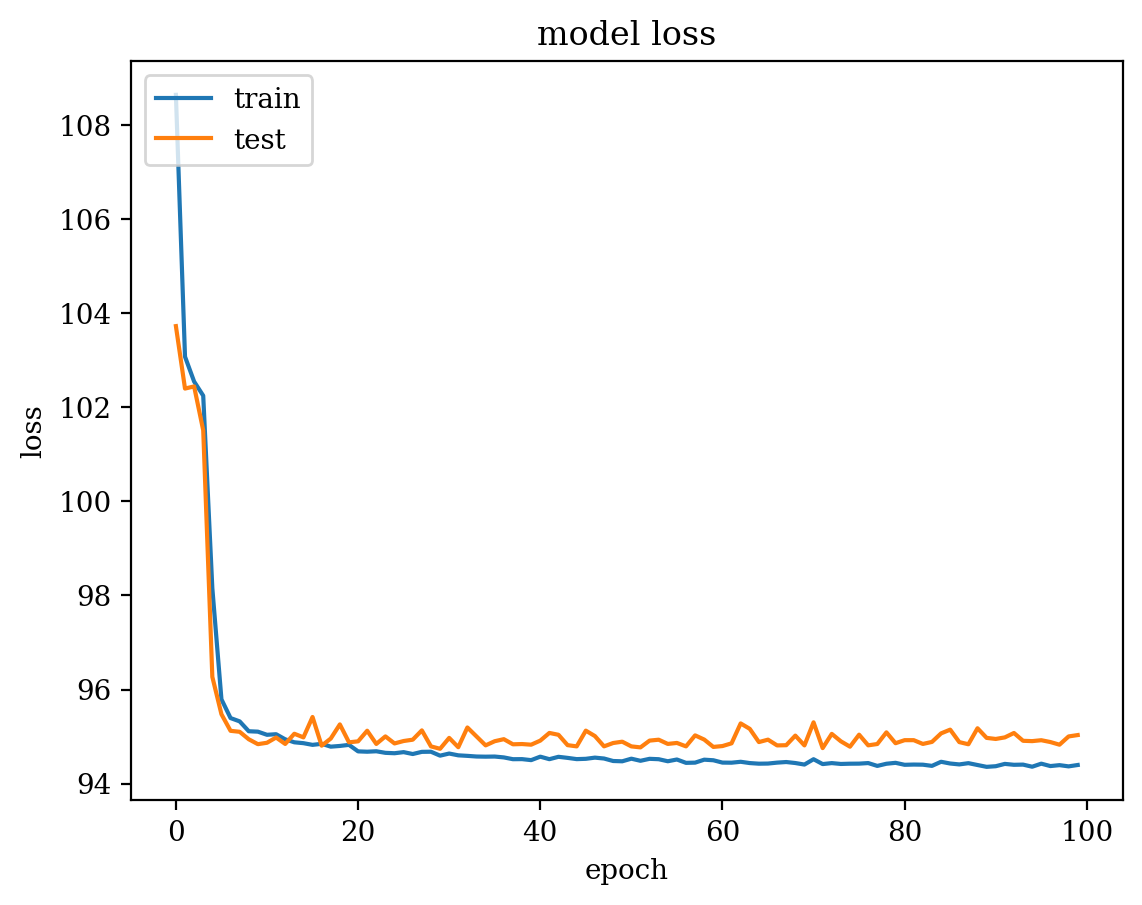

In [22]:
model.summary()
print(trained_model.history.keys())
# summarize history for accuracy
plt.plot(trained_model.history['mse'])
plt.plot(trained_model.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.save('curriculum_1.h5')

### Evaluation on the Test Set

16/16 [==============================] - 0s 6ms/step


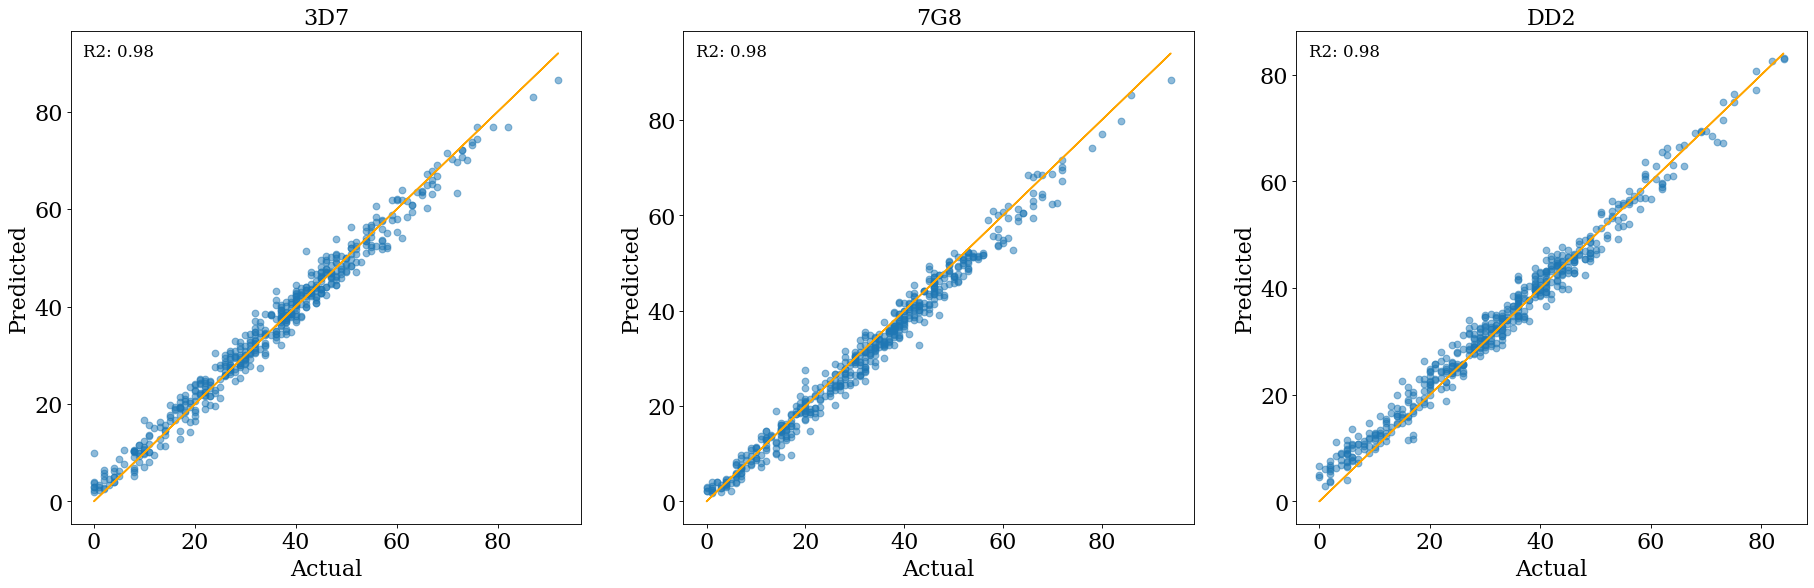

In [23]:
predict_array = model.predict(valid_alignments).tolist()

df_predict_curriculum_1 = pd.DataFrame(predict_array)
df_actual_curriculum_1 = pd.DataFrame(valid_prob_lists)

# Setup the headers
df_predict_curriculum_1.columns = clone_names
df_actual_curriculum_1.columns = clone_names

plt.figure(figsize=(4 + (8*len(clone_names)), 8), dpi=80)
for i in range(0,len(clone_names)):
    plt.subplot(1, len(clone_names), i+1)
    r2_curriculum_1 = r2_score(df_actual_curriculum_1[clone_names[i]], df_predict_curriculum_1[clone_names[i]])
    yp_1 = np.polyval([1, 0], df_actual_curriculum_1[clone_names[i]])
    plt.plot(df_actual_curriculum_1[clone_names[i]], yp_1, color='orange')
    plt.title('{seq_name}'.format(seq_name=clone_names[i]),fontsize=20,**hfont)
    plt.text(0.025, 0.975, 'R2: {r2_bp_bin_score}'.format(r2_bp_bin_score=round(r2_curriculum_1,2)),
            horizontalalignment='left',
            verticalalignment='top',
            transform=plt.gca().transAxes,fontsize=15,**hfont)
    plt.ylabel('Predicted',fontsize=20,**hfont)
    plt.yticks(fontsize=20,**hfont)
    plt.xlabel('Actual',fontsize=20,**hfont)
    plt.xticks(fontsize=20,**hfont)
    plt.scatter(df_actual_curriculum_1[clone_names[i]], df_predict_curriculum_1[clone_names[i]],alpha=0.5)


### Print the MSE Score for Each Clones

In [24]:
ax = 0
mse_curriculum_1 = []

for i in range(0,len(clone_names)):
    mse_curriculum_1.append(((df_predict_curriculum_1[clone_names[i]] - df_actual_curriculum_1[clone_names[i]])**2).mean(axis=ax))

for i in range(0,len(clone_names)):
    print_string = str(mse_curriculum_1[i])
    print(print_string)

6.3566327363127115
7.170421984441097
6.939021535261625


[link text](https://)### Print the Predicted Score for Single Pile-up

In [25]:
print(valid_prob_lists[1])
print(df_predict_curriculum_1.iloc[1])

[42. 43. 15.]
3D7    42.239468
7G8    41.925873
DD2    15.834660
Name: 1, dtype: float64


### Creating the VariantCalling *class* object to Synthesise Pile-ups from Pickle Files

In [26]:
dg = vc.VariantCallingData(file_name=ref_file_name,gen_mode=2,pkl_sequence=run_sequence,pkl_clones=clone_names)
alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,0.01,0.01)
prob_lists = (np.array(prob_lists)*100).tolist()
alignments = [dg._array_constituent_bp(i,101,True) for i in alignments_raw]
alignments = dg.char_to_int(alignments)

Progress:  0.0% completed. 	Computing alignment 0 of 2500
Progress:  5.0% completed. 	Computing alignment 125 of 2500
Progress:  10.0% completed. 	Computing alignment 250 of 2500
Progress:  15.0% completed. 	Computing alignment 375 of 2500
Progress:  20.0% completed. 	Computing alignment 500 of 2500
Progress:  25.0% completed. 	Computing alignment 625 of 2500
Progress:  30.0% completed. 	Computing alignment 750 of 2500
Progress:  35.0% completed. 	Computing alignment 875 of 2500
Progress:  40.0% completed. 	Computing alignment 1000 of 2500
Progress:  45.0% completed. 	Computing alignment 1125 of 2500
Progress:  50.0% completed. 	Computing alignment 1250 of 2500
Progress:  55.0% completed. 	Computing alignment 1375 of 2500
Progress:  60.0% completed. 	Computing alignment 1500 of 2500
Progress:  65.0% completed. 	Computing alignment 1625 of 2500
Progress:  70.0% completed. 	Computing alignment 1750 of 2500
Progress:  75.0% completed. 	Computing alignment 1875 of 2500
Progress:  80.0% com

### Display the Pile-ups for Documentation

[56.00000000000001, 19.0, 25.0]


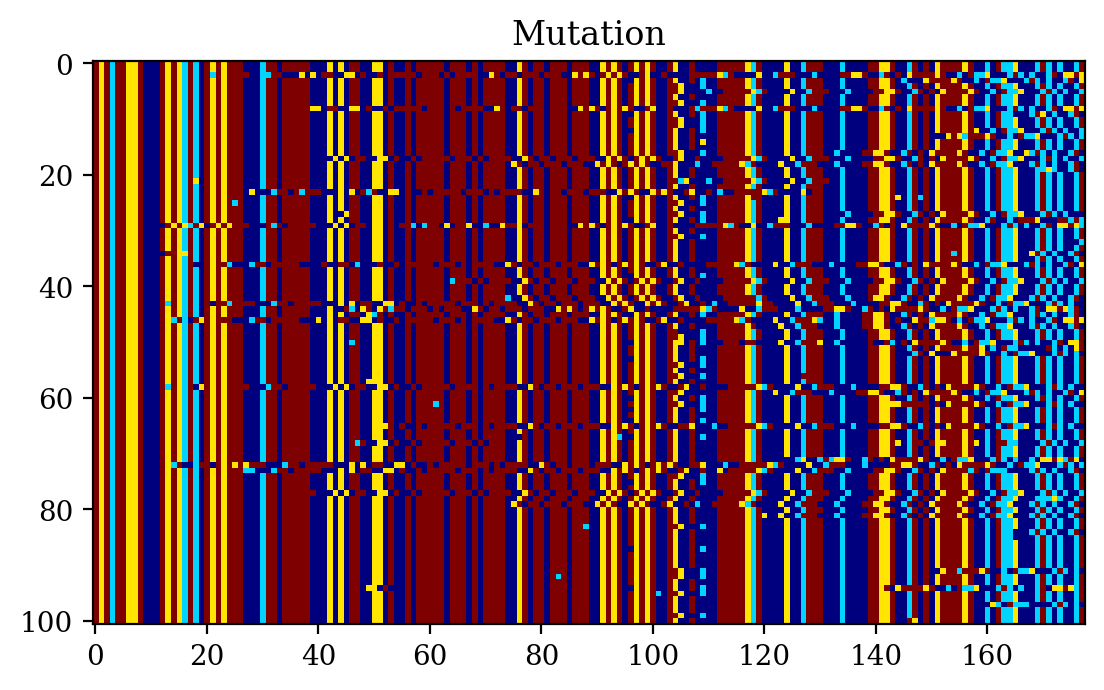

In [27]:
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.title("Mutation")
plt.imshow(dg.char_to_int([dg._array_dup(alignments_raw[0],101)])[0][0],cmap='jet')
print(prob_lists[0])

### Display the Binary Map (also for documentation)

[56.00000000000001, 19.0, 25.0]


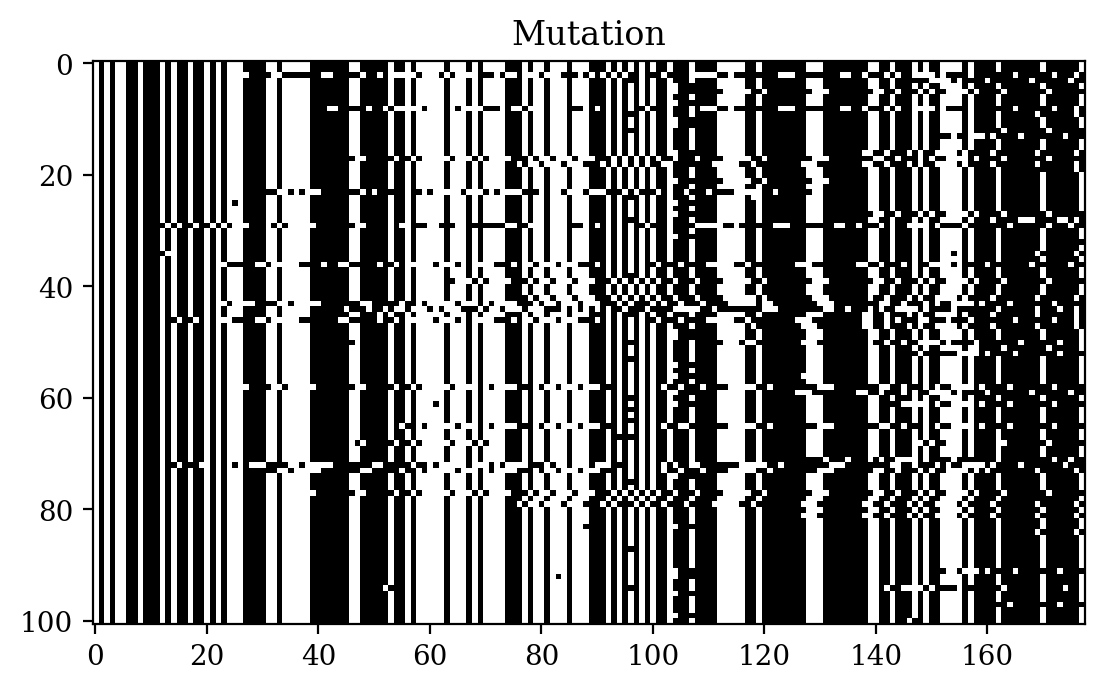

In [28]:
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.title("Mutation")
plt.imshow(alignments[0][1], cmap='Greys_r')
#test_array = np.zeros((178, 100))
#plt.imshow(test_array, cmap='Greys')
print(prob_lists[0])

### Pre-process the Synthesised Pile-ups into Train/Test Set

In [29]:
rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
idxs = np.arange(alignments.shape[0])

rng.shuffle(idxs)

split_idx = int(alignments.shape[0]*0.8)
train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
#train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]

print(train_alignments.shape)
print(valid_alignments.shape)


train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)

train_alignments = train_alignments.astype('float32')
valid_alignments = valid_alignments.astype('float32')

train_alignments /= 3
valid_alignments /= 3


(2000, 5, 101, 178)
(500, 5, 101, 178)


### Initial Training and Follow-up Training

In [33]:
# Here we first train the model
save_best_model = SaveBestModel()
trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
model.set_weights(save_best_model.best_weights)

# Here we resynthesise the pile-ups and continue the trainig using fresh data.
# Primarily because the memory constraints on Colab

for _ in range(0,train_loop):
    """
    This section to test ratio_gen, which is wrapper for alignments
    """
    alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,0.01,0.01)
    prob_lists = (np.array(prob_lists)*100).tolist()
    alignments = [dg._array_constituent_bp(i,101,True) for i in alignments_raw]
    alignments = dg.char_to_int(alignments)
    rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
    idxs = np.arange(alignments.shape[0])
    rng.shuffle(idxs)
    split_idx = int(alignments.shape[0]*0.8)
    train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
    train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
    #train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
    print(train_alignments.shape)
    print(train_prob_lists.shape)
    print(train_alignments.shape)
    print(valid_alignments.shape)
    train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
    valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)
    train_alignments = train_alignments.astype('float32')
    valid_alignments = valid_alignments.astype('float32')
    train_alignments /= 3
    valid_alignments /= 3
    trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
    model.set_weights(save_best_model.best_weights)

Epoch 1/100
125/125 [==============================] - 1s 8ms/step - loss: 94.4287 - mse: 8.9451 - val_loss: 95.6987 - val_mse: 32.1080
Epoch 2/100
125/125 [==============================] - 1s 10ms/step - loss: 94.4313 - mse: 8.7185 - val_loss: 96.0496 - val_mse: 38.5007
Epoch 3/100
125/125 [==============================] - 1s 9ms/step - loss: 94.4101 - mse: 8.5930 - val_loss: 95.6266 - val_mse: 30.7252
Epoch 4/100
125/125 [==============================] - 1s 10ms/step - loss: 94.4557 - mse: 9.2785 - val_loss: 95.8372 - val_mse: 35.0110
Epoch 5/100
125/125 [==============================] - 1s 10ms/step - loss: 94.4103 - mse: 8.3151 - val_loss: 95.9007 - val_mse: 36.6447
Epoch 6/100
125/125 [==============================] - 1s 10ms/step - loss: 94.3715 - mse: 7.7683 - val_loss: 95.7194 - val_mse: 32.3985
Epoch 7/100
125/125 [==============================] - 1s 10ms/step - loss: 94.3684 - mse: 7.4836 - val_loss: 95.6383 - val_mse: 31.5826
Epoch 8/100
125/125 [======================

### Evaluate the Model Performance

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 20, 35, 48)        6048      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 11, 48)        0         
 2D)                                                             
                                                                 
 activation_6 (Activation)   (None, 6, 11, 48)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 3, 48)          57648     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 1, 48)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 1, 1, 48)         

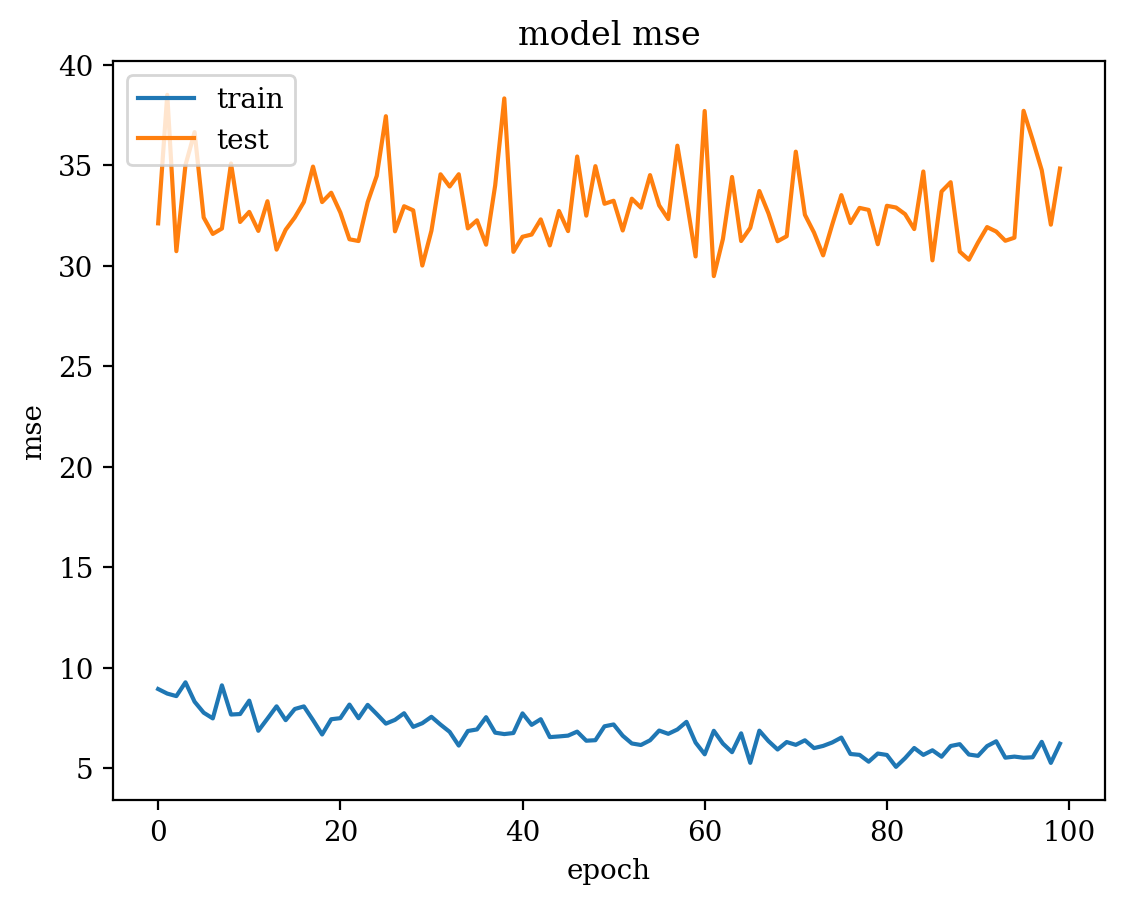

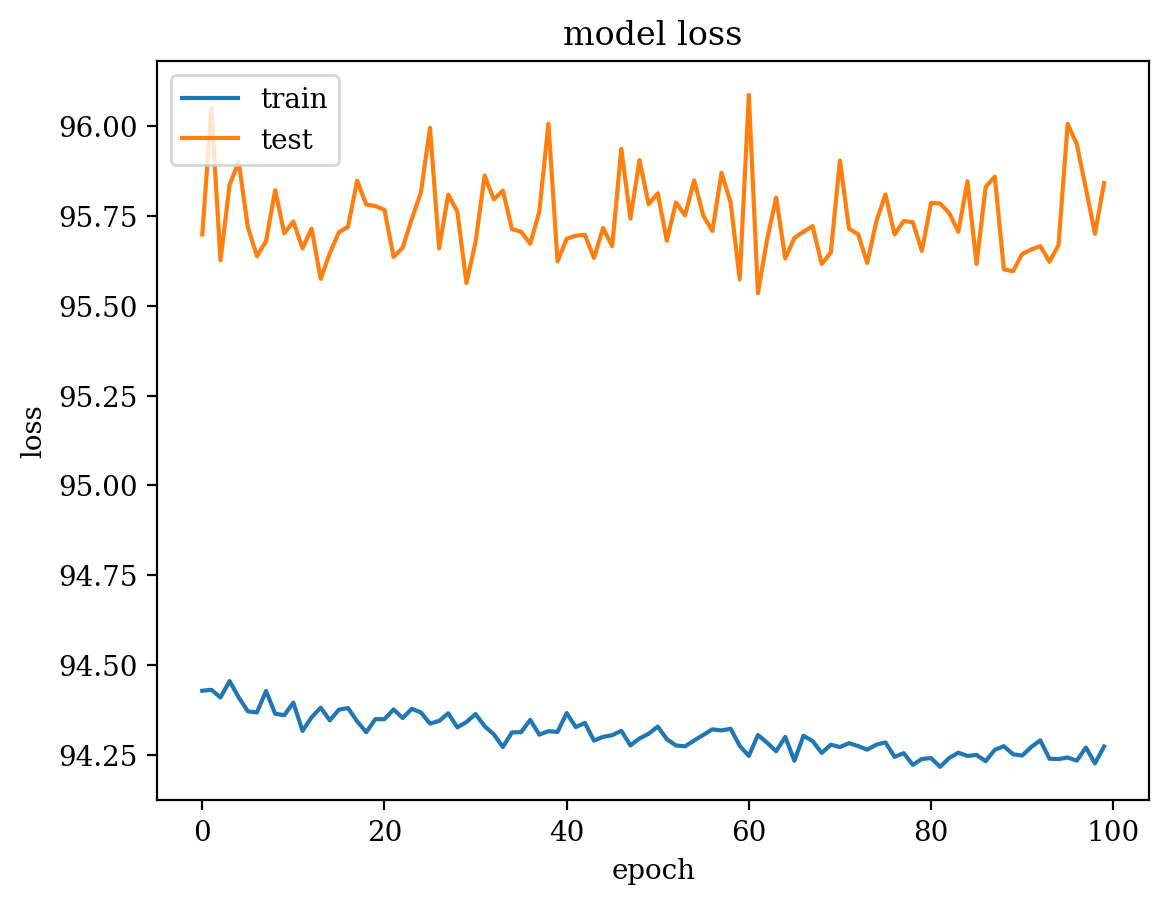

In [34]:
model.summary()
print(trained_model.history.keys())
# summarize history for accuracy
plt.plot(trained_model.history['mse'])
plt.plot(trained_model.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.save('curriculum_2.h5')

### Evaluation on the Test Set

16/16 [==============================] - 0s 6ms/step


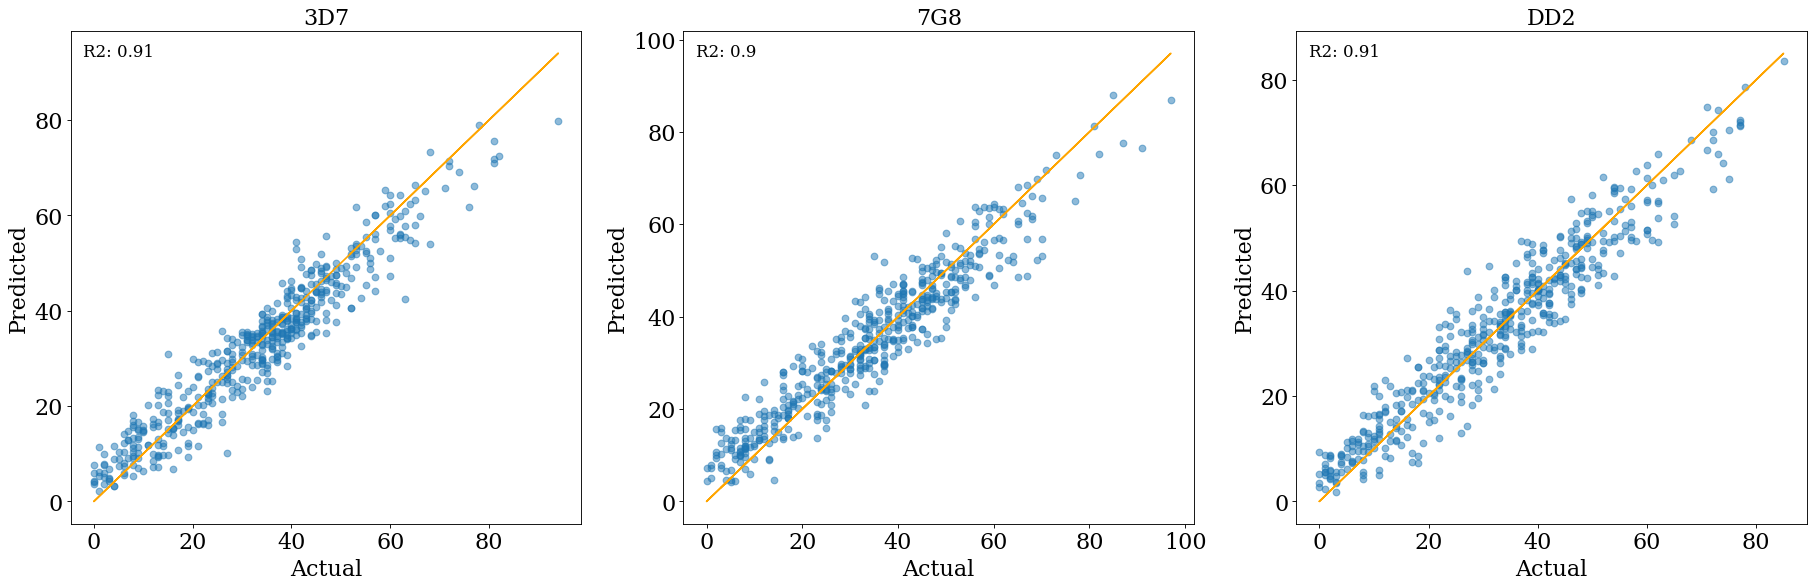

In [35]:
predict_array = model.predict(valid_alignments).tolist()

df_predict_curriculum_2 = pd.DataFrame(predict_array)
df_actual_curriculum_2 = pd.DataFrame(valid_prob_lists)

# Setup the headers
df_predict_curriculum_2.columns = clone_names
df_actual_curriculum_2.columns = clone_names

plt.figure(figsize=(4 + (8*len(clone_names)), 8), dpi=80)
for i in range(0,len(clone_names)):
    plt.subplot(1, len(clone_names), i+1)
    r2_curriculum_2 = r2_score(df_actual_curriculum_2[clone_names[i]], df_predict_curriculum_2[clone_names[i]])
    yp_1 = np.polyval([1, 0], df_actual_curriculum_2[clone_names[i]])
    plt.plot(df_actual_curriculum_2[clone_names[i]], yp_1, color='orange')
    plt.title('{seq_name}'.format(seq_name=clone_names[i]),fontsize=20,**hfont)
    plt.text(0.025, 0.975, 'R2: {r2_bp_bin_score}'.format(r2_bp_bin_score=round(r2_curriculum_2,2)),
            horizontalalignment='left',
            verticalalignment='top',
            transform=plt.gca().transAxes,fontsize=15,**hfont)
    plt.ylabel('Predicted',fontsize=20,**hfont)
    plt.yticks(fontsize=20,**hfont)
    plt.xlabel('Actual',fontsize=20,**hfont)
    plt.xticks(fontsize=20,**hfont)
    plt.scatter(df_actual_curriculum_2[clone_names[i]], df_predict_curriculum_2[clone_names[i]],alpha=0.5)


### Print the MSE Score for Each Clones

In [36]:
ax = 0
mse_curriculum_2 = []

for i in range(0,len(clone_names)):
    mse_curriculum_2.append(((df_predict_curriculum_2[clone_names[i]] - df_actual_curriculum_2[clone_names[i]])**2).mean(axis=ax))

for i in range(0,len(clone_names)):
    print_string = str(mse_curriculum_2[i])
    print(print_string)

26.38515663330422
34.640138489168045
27.431340329114605


### Print the Predicted Score for Single Pile-up

In [37]:
print(valid_prob_lists[1])
print(df_predict_curriculum_2.iloc[1])

[13. 57. 30.]
3D7    15.711687
7G8    50.693630
DD2    33.594677
Name: 1, dtype: float64
